The goal of this analysis is to identify customers that are likely to open a term deposit account. Understanding the financial goals of customers will enable Bank XYZ to tailor products and services to meet the specific needs of the customer. It will also allow for effective resource allocation and narrow targeted marketing strategies. Term accounts involve long-term commitments leading to longer-lasting customer relationships that add to the stability of Bank XYZ’s deposit base. This will lead to an enhanced overall risk management and financial planning strategy ensuring a more robust and sustainable business model. 

The data set was generated from a telephone calling marking campaign that occurred between May 2008 and November 2010. It includes 41,188 rows with 20 columns relating to the customer, the contact, previous contacts during the campaign, and social/economic context attributes.

# Libraries

In [1]:
import findspark
findspark.init()

In [2]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc, desc, when, explode, array, lit
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix
#from imblearn.over_sampling import SMOTE


spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.getOrCreate()

sc=spark.sparkContext
sqlContext=SQLContext(sc)

C:\Spark\spark-3.5.0-bin-hadoop3\spark-3.5.0-bin-hadoop3\python\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
# read in the dataframe for the assignment
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",";")\
 .csv("/Users/Jacob/Downloads/XYZ_Bank_Deposit_Data_Classification.csv")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.")

There are 41188 rows 21 columns in the data.


In [4]:
# Data Preprocessing
df = df.withColumnRenamed("emp.var.rate", "emp_var_rate")
df = df.withColumnRenamed("cons.price.idx", "cons_price_idx")
df = df.withColumnRenamed("cons.conf.idx", "cons_conf_idx")
df = df.withColumnRenamed("nr.employed", "nr_employed")

# Data Exploration

In [5]:
df.show(5)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 37| serv

In [6]:
df.summary().toPandas().transpose()

,0,1,2,3,4,5,6,7
summary,count,mean,stddev,min,25%,50%,75%,max
age,41188,40.02406040594348,10.421249980934043,17,32,38,47,98
job,41188,None,None,admin.,None,None,None,unknown
marital,41188,None,None,divorced,None,None,None,unknown
education,41188,None,None,basic.4y,None,None,None,unknown
default,41188,None,None,no,None,None,None,yes
housing,41188,None,None,no,None,None,None,yes
loan,41188,None,None,no,None,None,None,yes
contact,41188,None,None,cellular,None,None,None,telephone
month,41188,None,None,apr,None,None,None,sep


# Exploratory Data Visualizations 

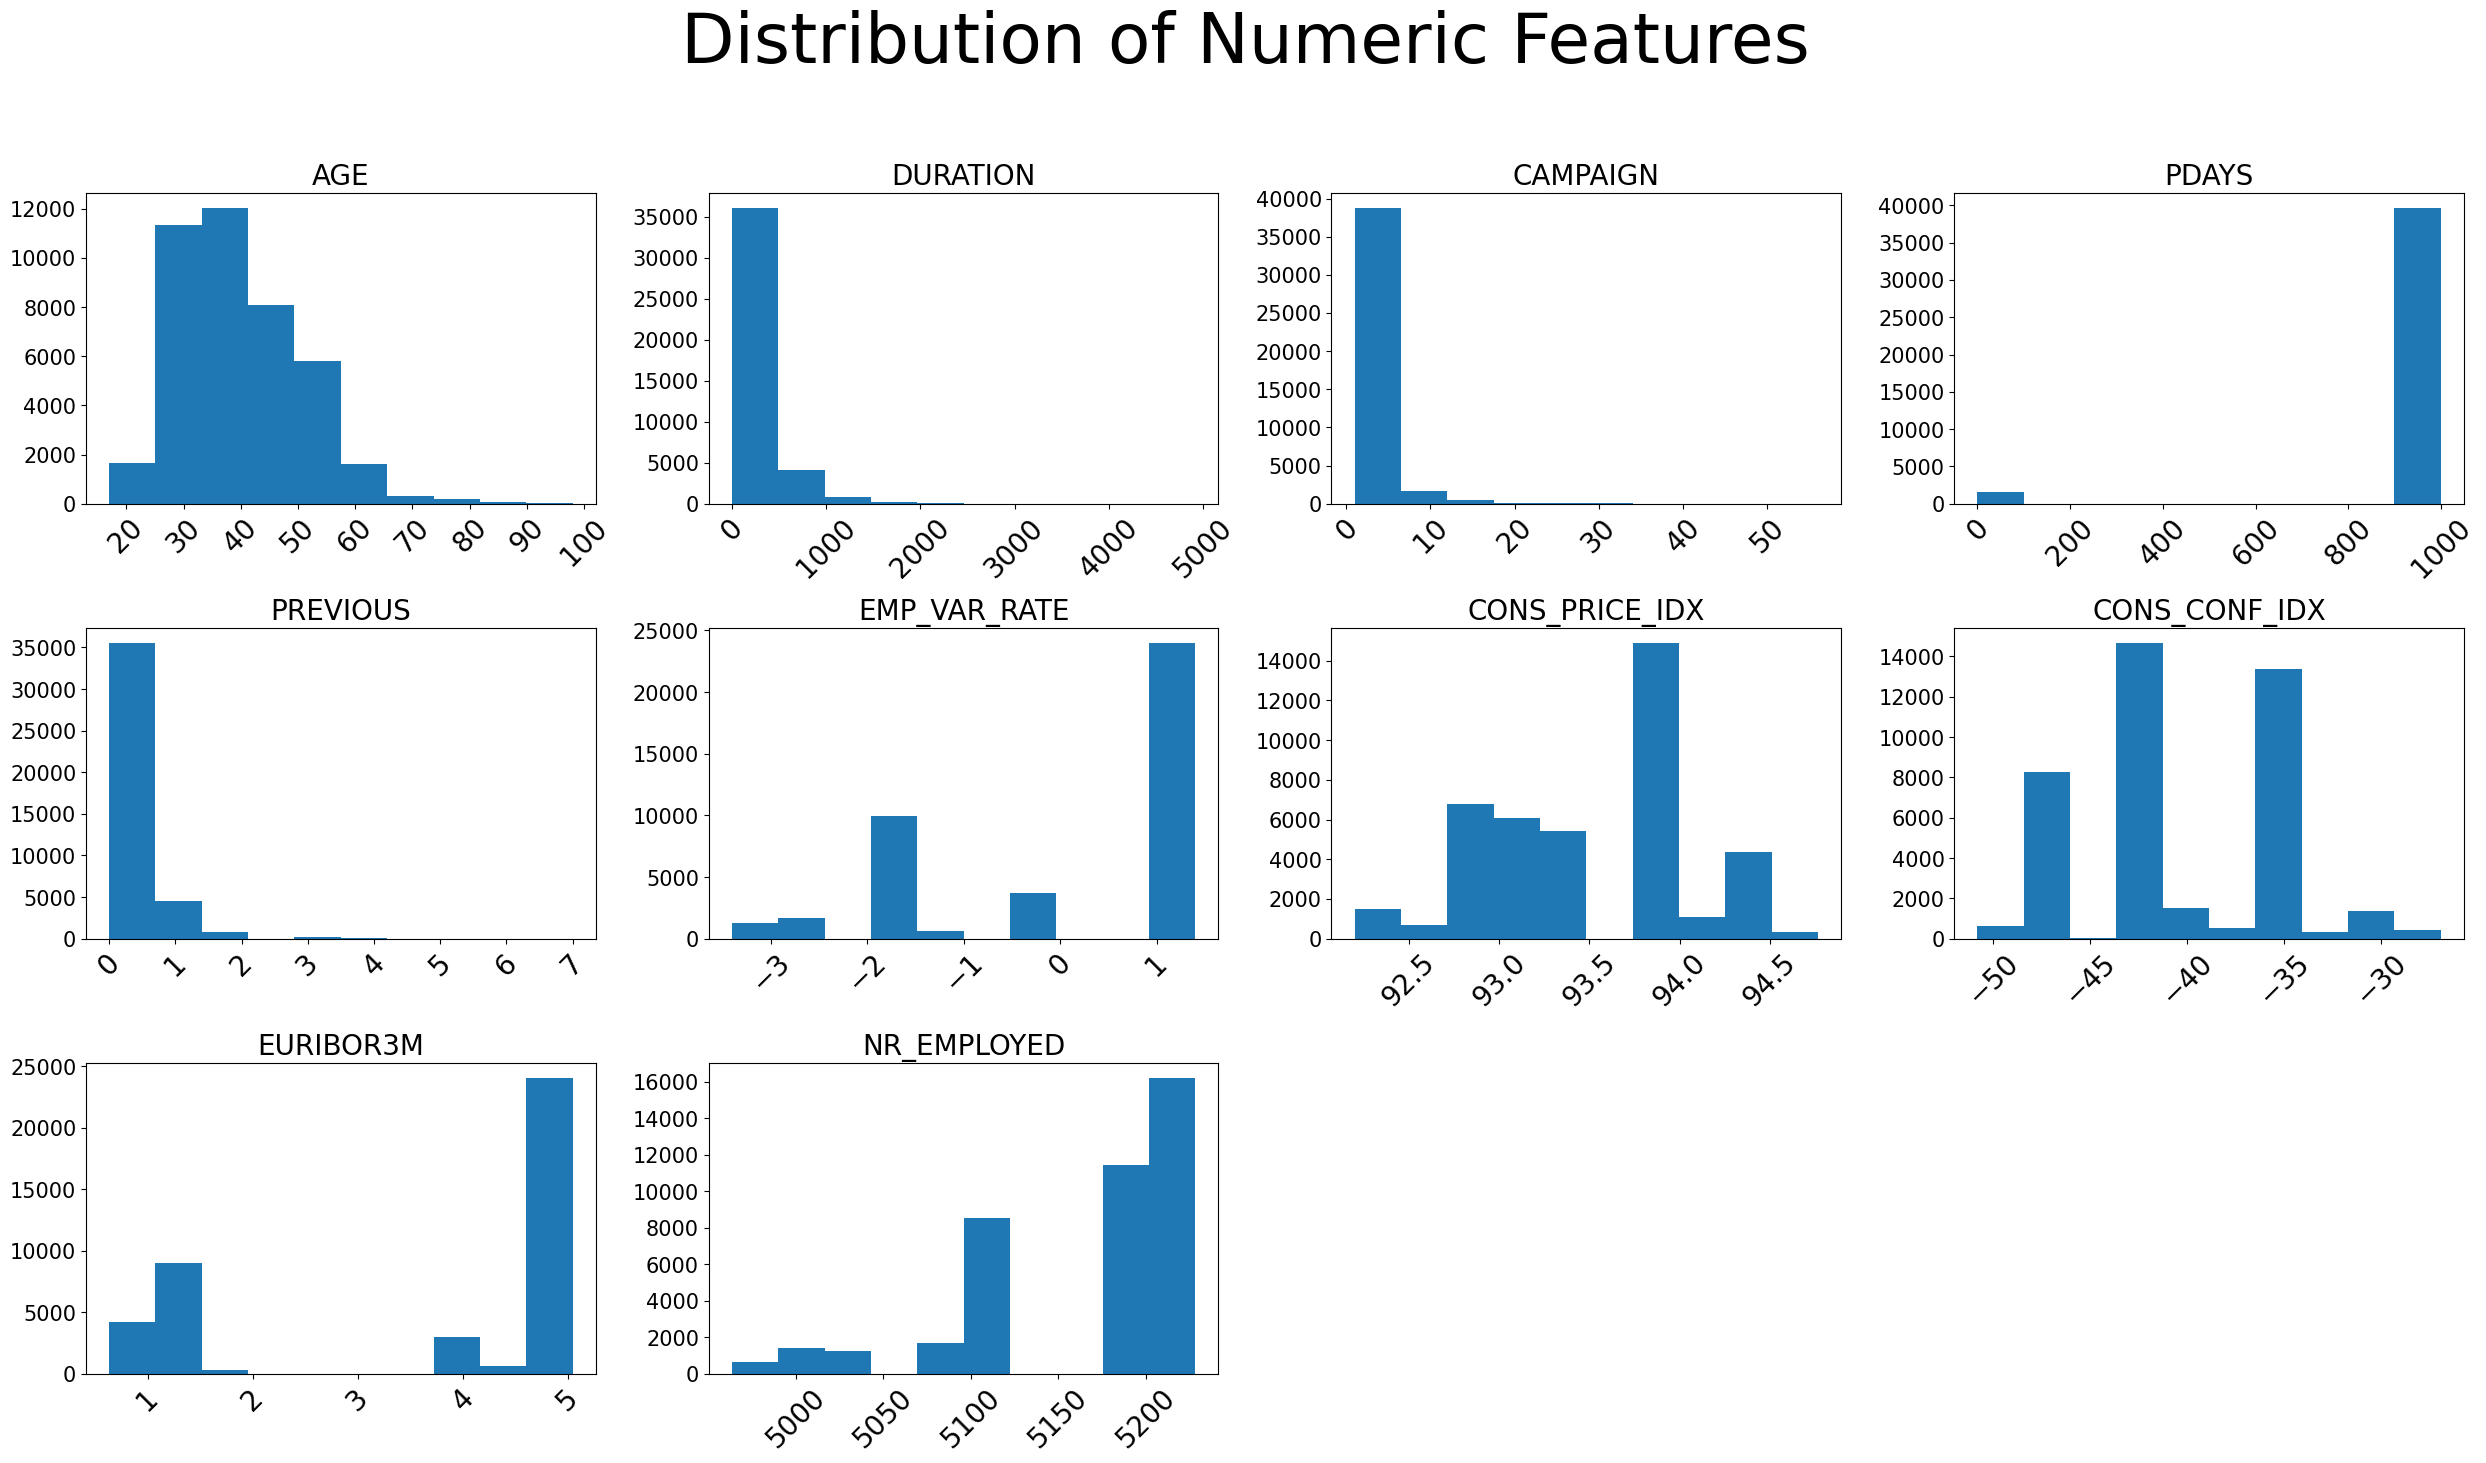

In [7]:
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Numeric Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df.toPandas().describe().columns, range(1,11)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

In [8]:
# Total string variables
string_features = [t[0] for t in df.dtypes if t[1] == 'string']

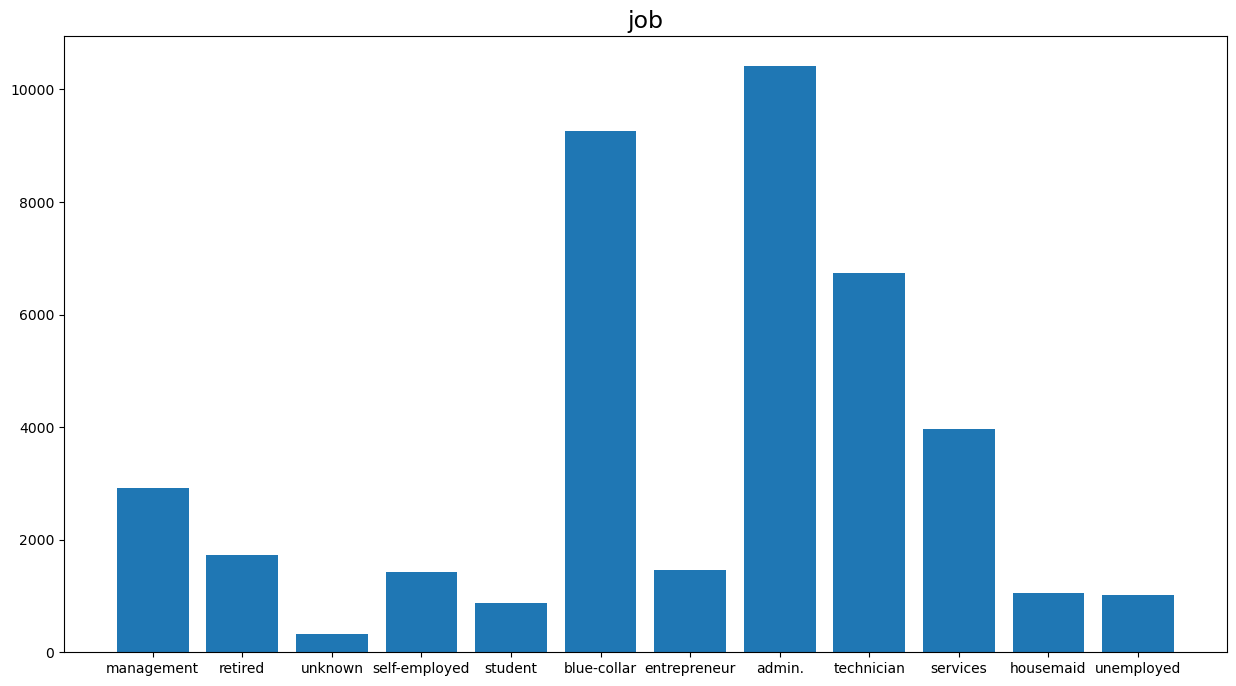

None

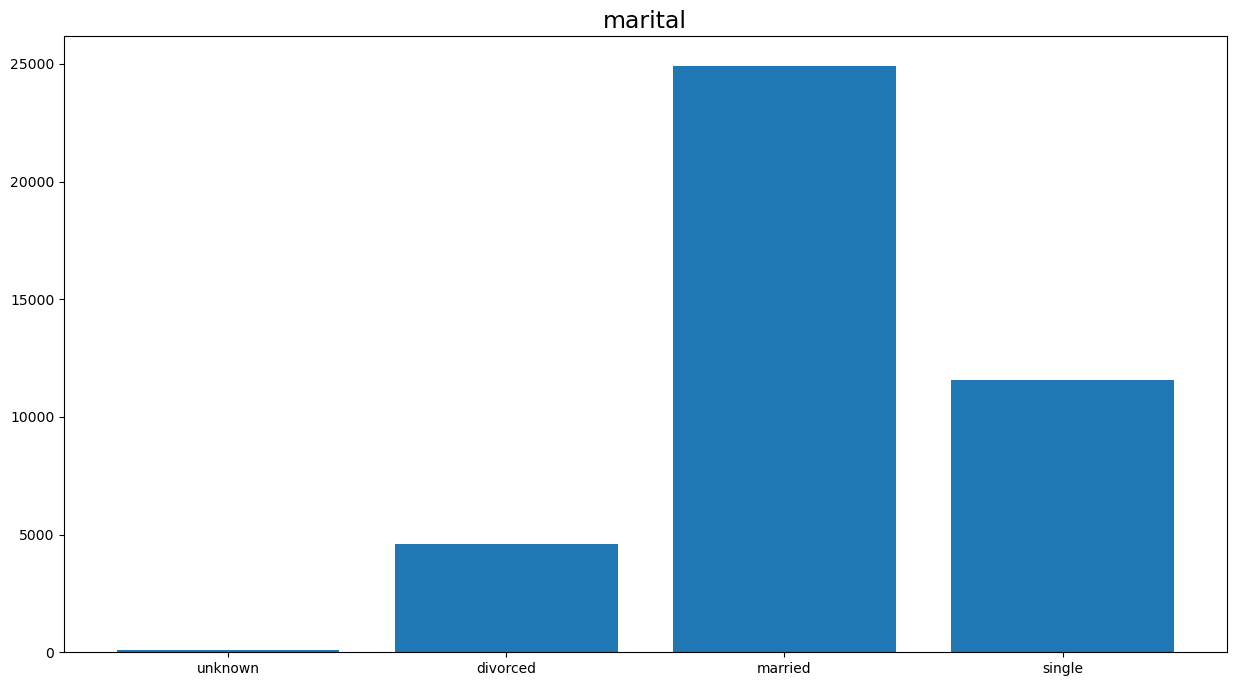

None

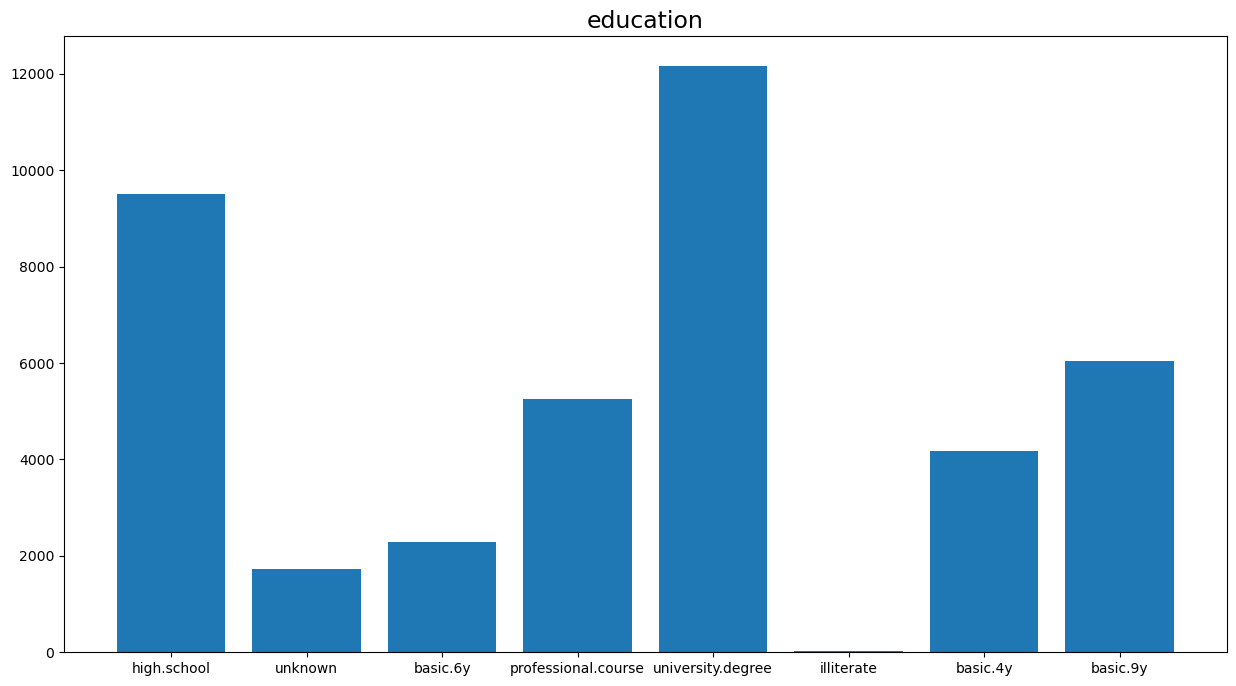

None

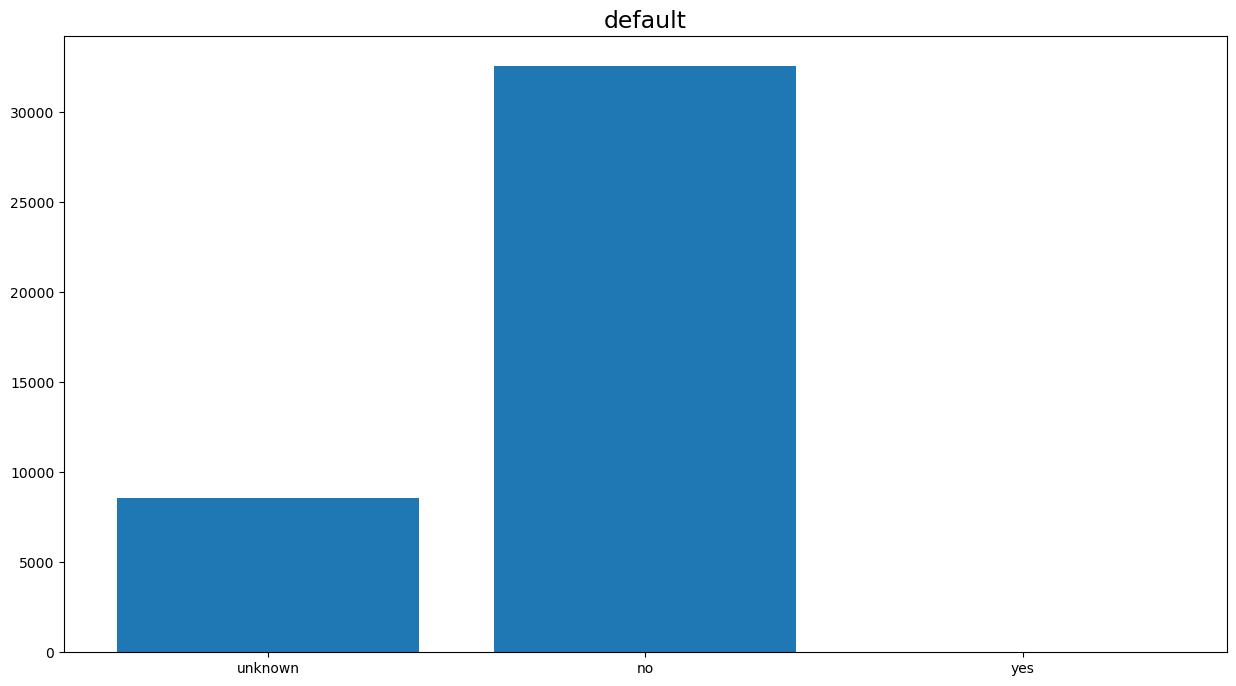

None

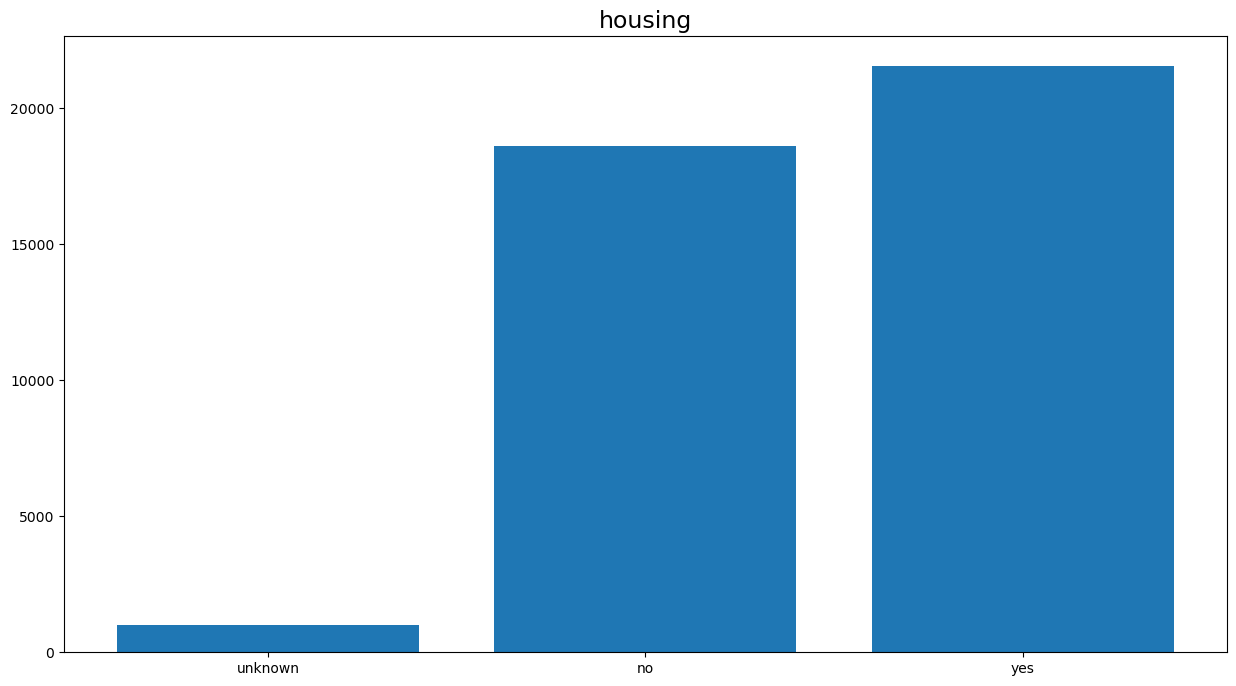

None

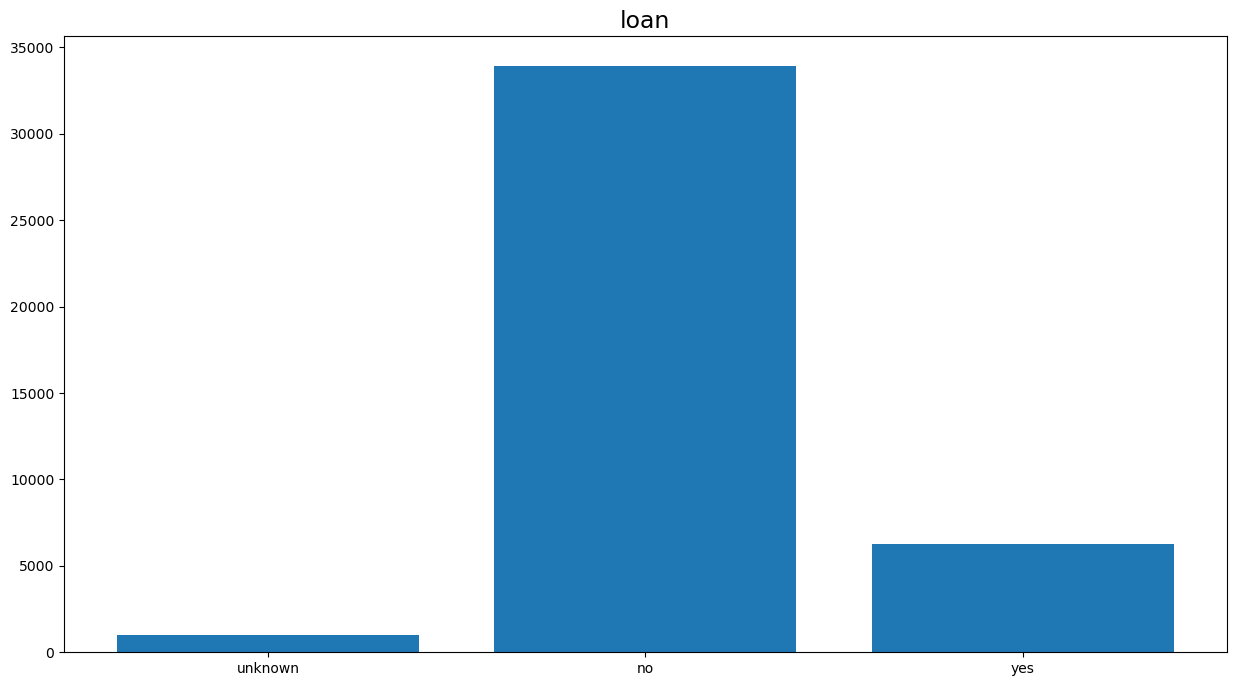

None

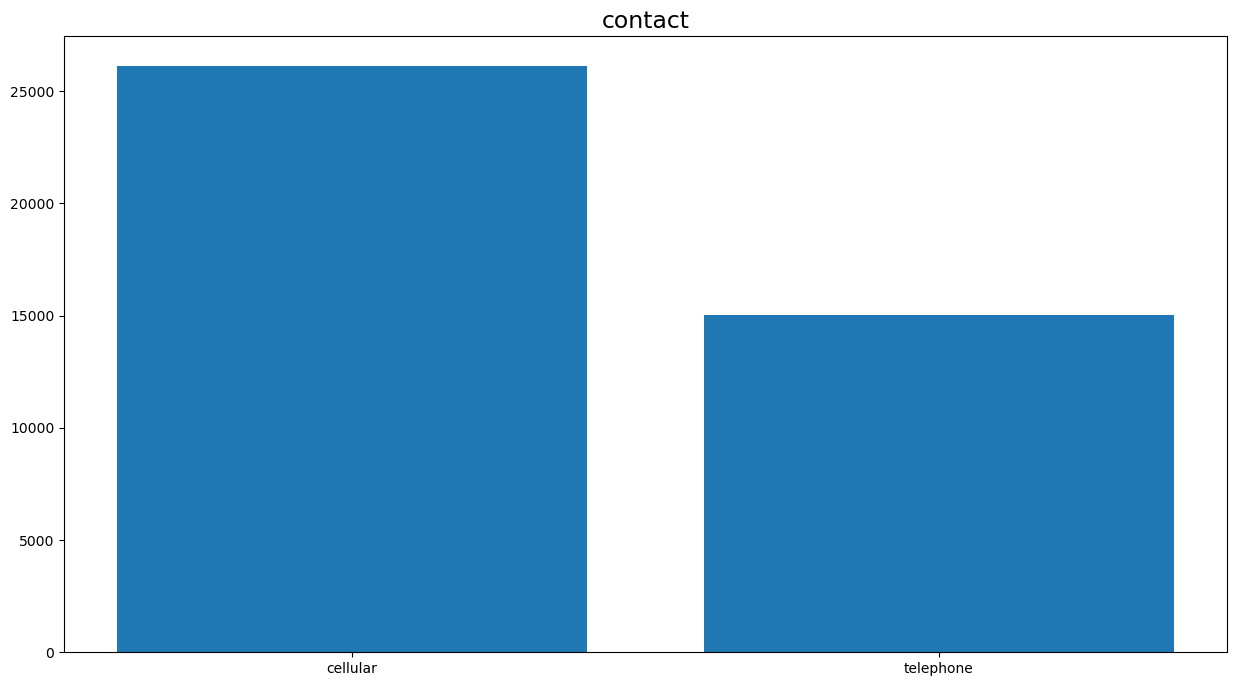

None

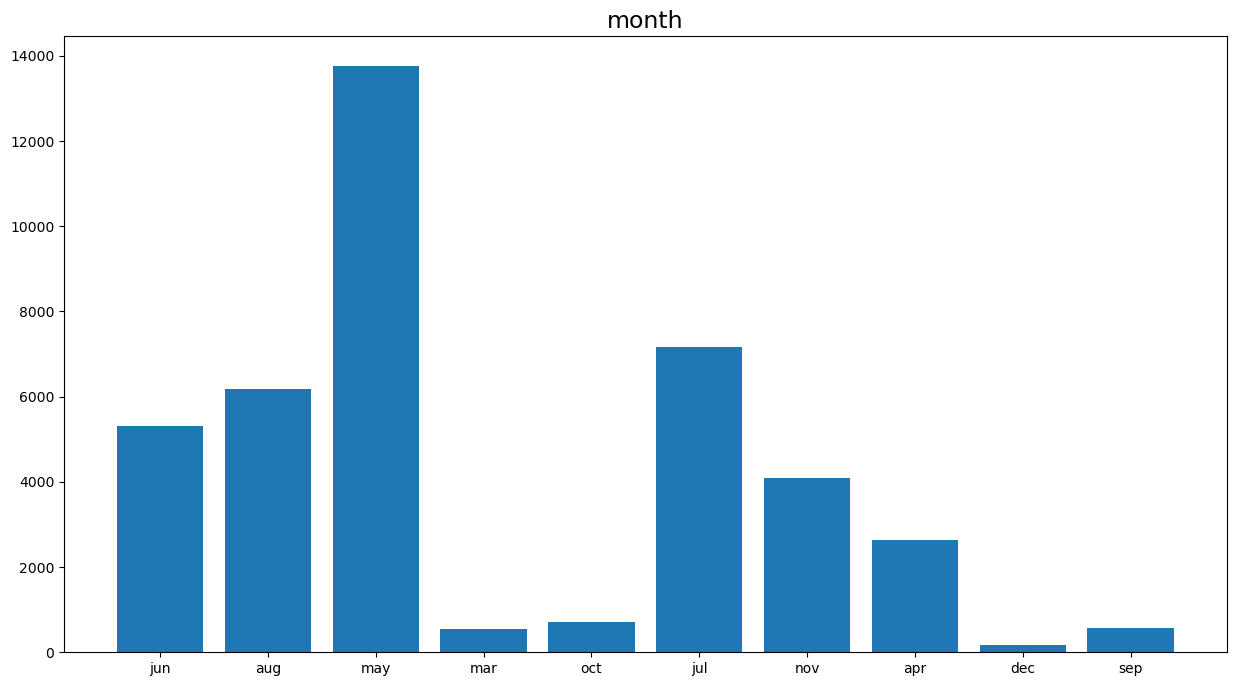

None

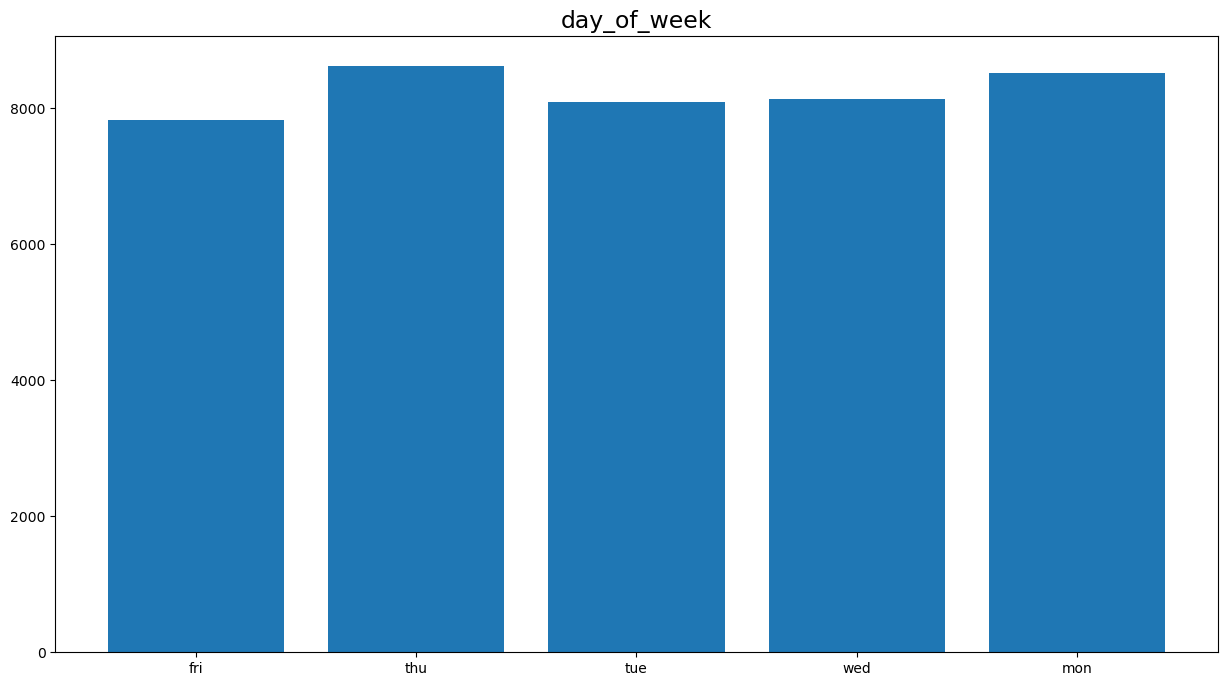

None

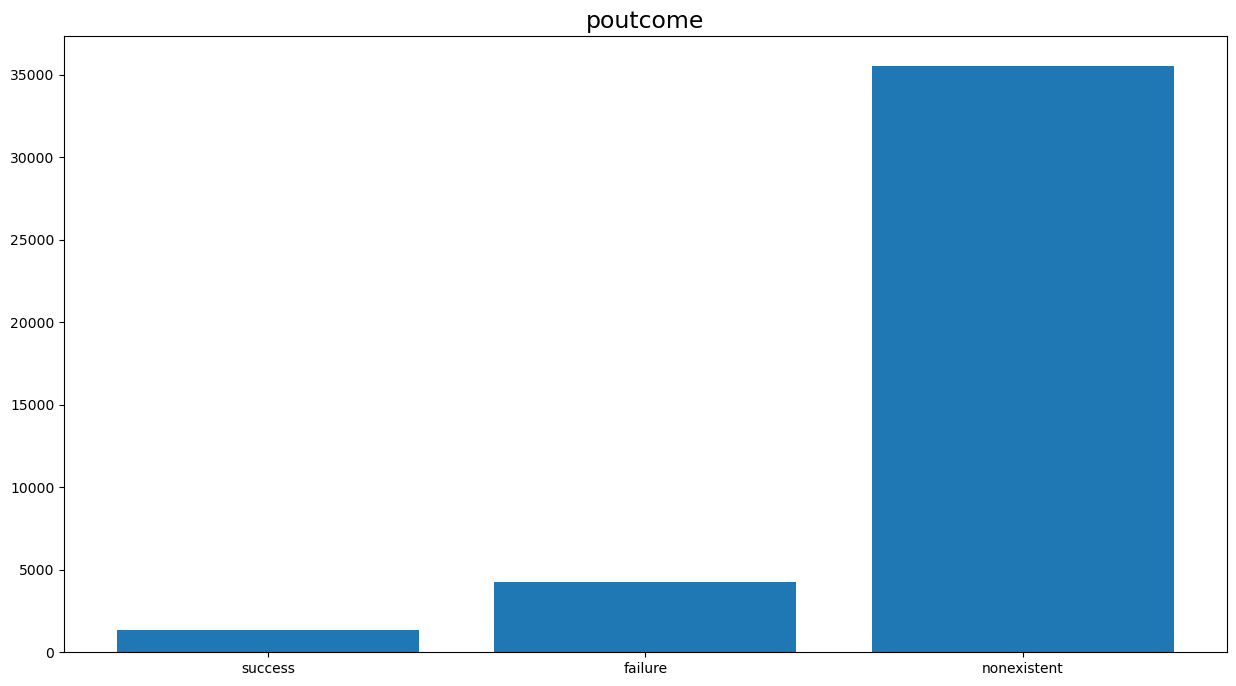

None

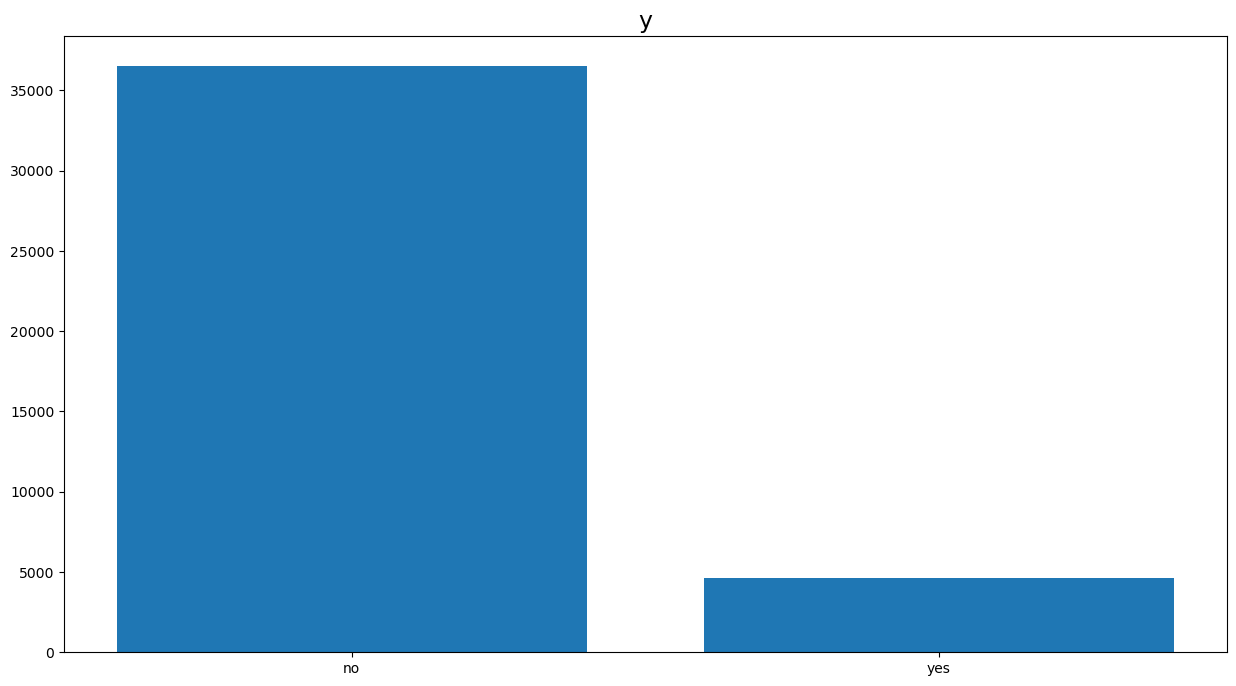

None

In [9]:
# A temporary view for the dataset
df.createOrReplaceTempView("DF")
for i in string_features:
    plt.figure(figsize=(15,8))
    new = spark.sql("select " + i + ", count(" + i + ") from DF group by " + i).toPandas()
    plt.bar(new.iloc[:,0], new.iloc[:,1])
    plt.title(i, fontdict={'fontsize': 17})
    display(plt.show())

## Correlation Matrix

In [7]:
# create df for correlation matrix
df1 = df[['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']]

In [8]:
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

columns = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=columns, 
                            outputCol=vector_col)
my_vector = assembler.transform(df1).select(vector_col)
matrix = Correlation.corr(my_vector, vector_col)

In [9]:
# create list for correlation
matrix = Correlation.corr(my_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()
print(corrmatrix)

[[1.0, -0.0008657050101409137, 0.004593580493413432, -0.034368951166858994, 0.02436474093611654, -0.00037068546744101216, 0.0008567149710785426, 0.12937161424620508, 0.010767429541674797, -0.017725131911927514], [-0.0008657050101409137, 1.0, -0.0716992262641536, -0.0475770154456121, 0.020640350701749122, -0.02796788448933175, 0.005312267762748574, -0.008172872813929487, -0.03289665570187576, -0.04470322316241789], [0.004593580493413432, -0.0716992262641536, 1.0, 0.052583573385026956, -0.07914147244884145, 0.15075380555786647, 0.12783591160945573, -0.013733098741901751, 0.13513251080435904, 0.14409489484472365], [-0.034368951166858994, -0.0475770154456121, 0.052583573385026956, 1.0, -0.587513856136789, 0.27100417426183293, 0.0788891087159522, -0.09134235397835197, 0.29689911239700334, 0.37260474218583123], [0.02436474093611654, 0.020640350701749122, -0.07914147244884145, -0.587513856136789, 1.0, -0.42048910941333256, -0.2031299674503254, -0.05093635090673017, -0.45449365360773475, -0.50

In [10]:
# show correlation matrix
corr_df = spark.createDataFrame(corrmatrix,columns)
corr_df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 age|            duration|            campaign|               pdays|            previous|        emp_var_rate|      cons_price_idx|       cons_conf_idx|           euribor3m|         nr_employed|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0|-8.65705010140913...|0.004593580493413432|-0.03436895116685...| 0.02436474093611654|-3.70685467441012...|8.567149710785426E-4| 0.12937161424620508|0.010767429541674797|-0.01772513191192...|
|-8.65705010140913...|                 1.0| -0.0716992262641536| -0.0475770154456121|0.020640350701749122|-0.02796788448933175|0.005312267762748574|-0.0

C:\Users\Jacob\AppData\Local\Temp\ipykernel_9236\2978521685.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+attr)
C:\Users\Jacob\AppData\Local\Temp\ipykernel_9236\2978521685.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+attr)


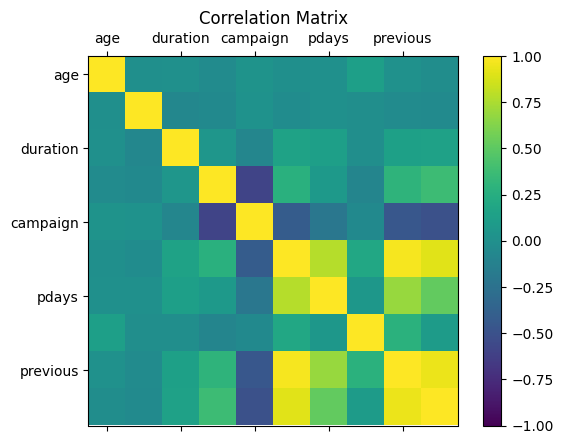

In [11]:
def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no)
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

plot_corr_matrix(corrmatrix, columns, 234)

## Boxplots

In [12]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline

# conversion
df2 = df.toPandas()

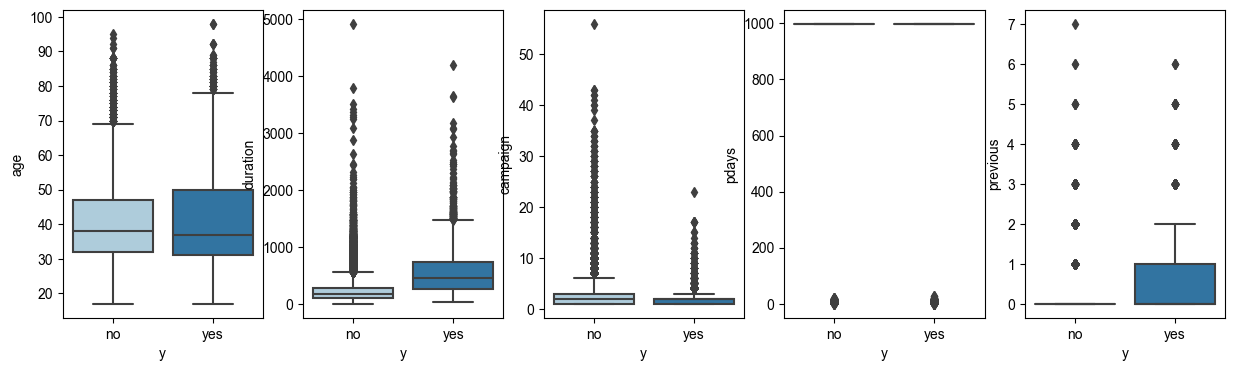

In [13]:
sns.set_palette('Paired')
f, axes = plt.subplots(nrows=1, ncols=5, figsize = (15,4))
sns.set_style('darkgrid')

fig1 = sns.boxplot(x='y', y='age', data=df2, ax=axes[0])
fig2 = sns.boxplot(x='y', y='duration', data=df2, ax=axes[1])
fig3 = sns.boxplot(x='y', y='campaign', data=df2, ax=axes[2])
fig4 = sns.boxplot(x='y', y='pdays', data=df2, ax=axes[3])
fig5 = sns.boxplot(x='y', y='previous', data=df2, ax=axes[4])

plt.show()

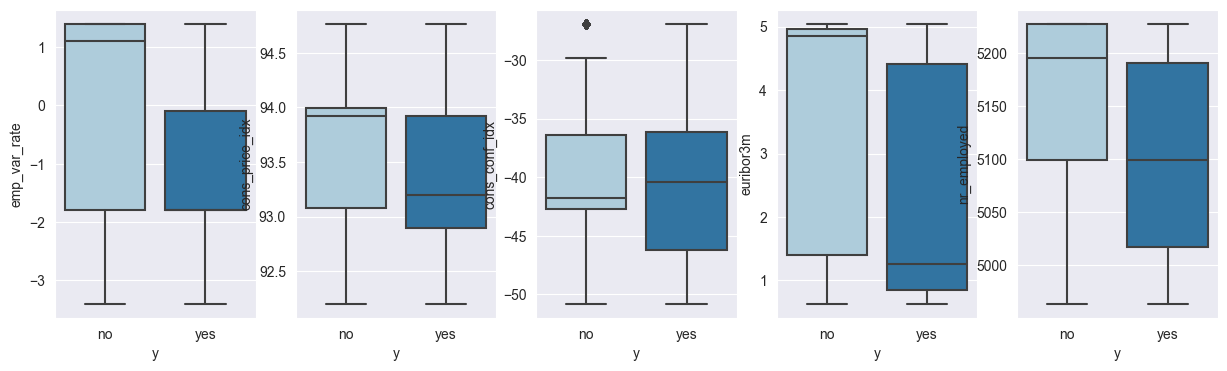

In [14]:
sns.set_palette('Paired')
f, axes = plt.subplots(nrows=1, ncols=5, figsize = (15,4))
sns.set_style('darkgrid')

fig6 = sns.boxplot(x='y', y='emp_var_rate', data=df2, ax=axes[0])
fig7 = sns.boxplot(x='y', y='cons_price_idx', data=df2, ax=axes[1])
fig8 = sns.boxplot(x='y', y='cons_conf_idx', data=df2, ax=axes[2])
fig9 = sns.boxplot(x='y', y='euribor3m', data=df2, ax=axes[3])
fig10 = sns.boxplot(x='y', y='nr_employed', data=df2, ax=axes[4])

plt.show()

# Bivariate Analysis

/Users/muralidhar/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


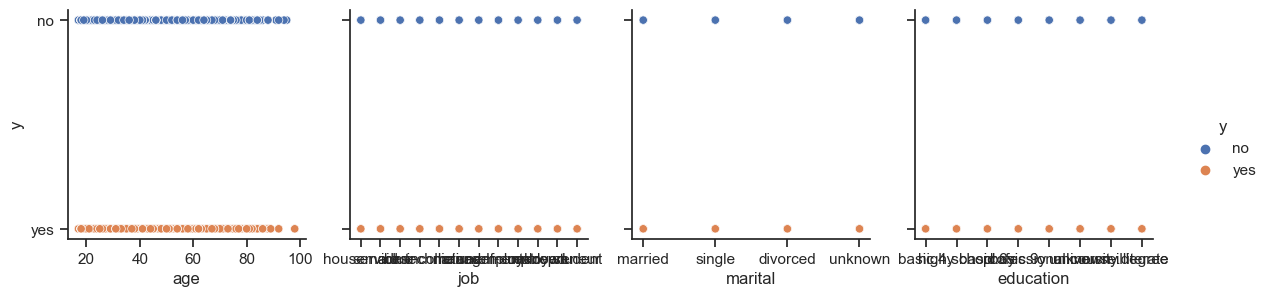

/Users/muralidhar/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


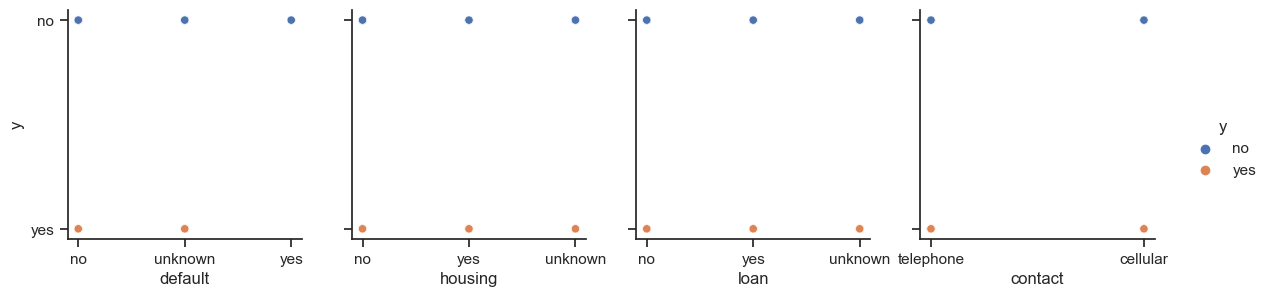

/Users/muralidhar/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


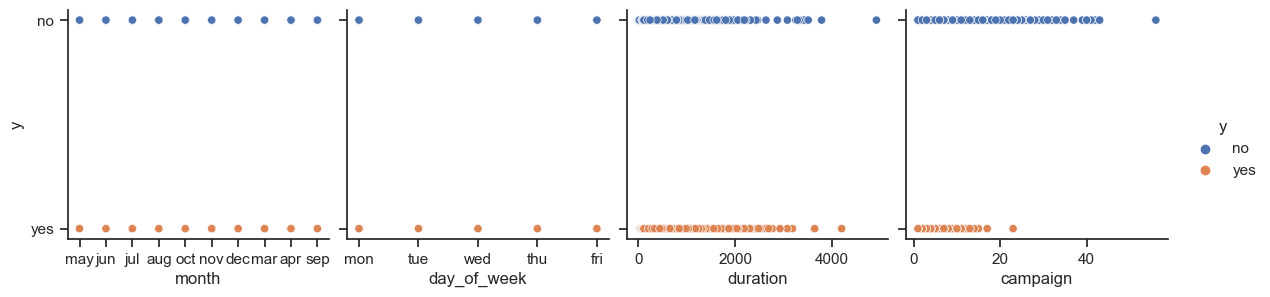

/Users/muralidhar/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


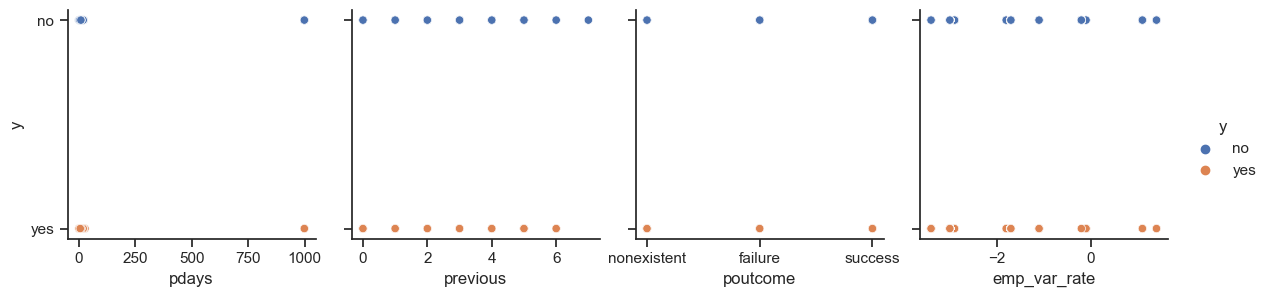

/Users/muralidhar/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


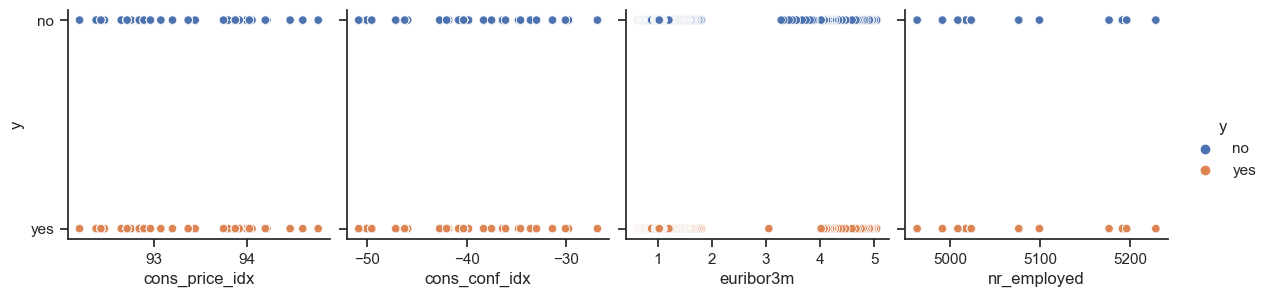

In [10]:
import seaborn as sns
sns.set(style="ticks")

for x in range(0,len(df.columns[:-1]), 4):
    sns.pairplot(df.toPandas(), x_vars=df.columns[x:(x+4)], y_vars="y", hue="y", height = 3)
    plt.show()

In [11]:
# Checking for null values in the dataset
{col:df.filter(df[col].isNull()).count() for col in df.columns}

{'age': 0,
 'job': 0,
 'marital': 0,
 'education': 0,
 'default': 0,
 'housing': 0,
 'loan': 0,
 'contact': 0,
 'month': 0,
 'day_of_week': 0,
 'duration': 0,
 'campaign': 0,
 'pdays': 0,
 'previous': 0,
 'poutcome': 0,
 'emp_var_rate': 0,
 'cons_price_idx': 0,
 'cons_conf_idx': 0,
 'euribor3m': 0,
 'nr_employed': 0,
 'y': 0}

In [12]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



In [13]:
# Total numeric variables
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934043,17,98
duration,41188,258.2850101971448,259.27924883646455,0,4918
campaign,41188,2.567592502670681,2.770013542902331,1,56
pdays,41188,962.4754540157328,186.910907344741,0,999
previous,41188,0.17296299893172767,0.49490107983928927,0,7
emp_var_rate,41188,0.08188550063178966,1.57095974051703,-3.4,1.4
cons_price_idx,41188,93.5756643682899,0.5788400489540823,92.201,94.767
cons_conf_idx,41188,-40.502600271918276,4.628197856174573,-50.8,-26.9
euribor3m,41188,3.621290812858533,1.7344474048512595,0.634,5.045


In [14]:
# cardinality for the categorical variables
from pyspark.sql.functions import countDistinct
cardinality = [countDistinct(c).alias(c) for c in string_features]
df.select(cardinality).show()

+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+---+
|job|marital|education|default|housing|loan|contact|month|day_of_week|poutcome|  y|
+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+---+
| 12|      4|        8|      3|      3|   3|      2|   10|          5|       3|  2|
+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+---+



In [15]:
for i in string_features:
    df.select(i).distinct().show()

+-------------+
|          job|
+-------------+
|   management|
|      retired|
|      unknown|
|self-employed|
|      student|
|  blue-collar|
| entrepreneur|
|       admin.|
|   technician|
|     services|
|    housemaid|
|   unemployed|
+-------------+

+--------+
| marital|
+--------+
| unknown|
|divorced|
| married|
|  single|
+--------+

+-------------------+
|          education|
+-------------------+
|        high.school|
|            unknown|
|           basic.6y|
|professional.course|
|  university.degree|
|         illiterate|
|           basic.4y|
|           basic.9y|
+-------------------+

+-------+
|default|
+-------+
|unknown|
|     no|
|    yes|
+-------+

+-------+
|housing|
+-------+
|unknown|
|     no|
|    yes|
+-------+

+-------+
|   loan|
+-------+
|unknown|
|     no|
|    yes|
+-------+

+---------+
|  contact|
+---------+
| cellular|
|telephone|
+---------+

+-----+
|month|
+-----+
|  jun|
|  aug|
|  may|
|  mar|
|  oct|
|  jul|
|  nov|
|  apr|
|  dec|
|  sep|

# Splitting the dataset into training and test 

In [16]:
df1 = df
train, test = df1.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 32894
Test Dataset Count: 8294


## Oversample the minority class

In [17]:
# compute ratio needed to oversample

from pyspark.sql.functions import col
major_df = train.filter(col("y") == 'no')
minor_df = train.filter(col("y") == 'yes')
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

ratio: 7


In [18]:
a = range(ratio)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
train = major_df.unionAll(oversampled_df)

# Feature Engineering/ Data Preprocessing

In [19]:
# For the string features
stages = []
for col in string_features[:-1]:
    stringIndexer = StringIndexer(inputCol=col, outputCol=col + 'coded')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[col + "classVec"])
    stages += [stringIndexer, encoder]

# for the outcome label
label_string = StringIndexer(inputCol= 'y', outputCol='label')
stages += [label_string]

# for the numerical columns as well
assemblerInputs = [c + 'classVec' for c in string_features[:-1]] + numeric_features
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='vectorized_features', handleInvalid='skip')
stages += [assembler]

# scale down the features into something usable
scaler = StandardScaler(inputCol='vectorized_features', outputCol='features')
stages += [scaler]

In [20]:
cols = train.columns
pipeline = Pipeline(stages=stages)
pipelinemodel = pipeline.fit(train)
train = pipelinemodel.transform(train)
selectedCols = ['label', 'features'] + cols
train_set = train.select(selectedCols)

In [21]:
cols = test.columns
test = pipelinemodel.transform(test)
selectedCols = ['label', 'features'] + cols
test_set = test.select(selectedCols)

# Logistic Regression

In [22]:
# training for the logistic regression
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train_set)
predictions = lrModel.transform(test_set)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

23/11/28 10:05:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/11/28 10:05:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


,label,features,rawPrediction,prediction,probability
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[2.58489651602412, -2.58489651602412]",0.0,"[0.9298831968782764, 0.07011680312172364]"
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[0.2997056847910464, -0.2997056847910464]",0.0,"[0.5743705674367132, 0.4256294325632868]"
2,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[-1.7709120160390945, 1.7709120160390945]",1.0,"[0.14542894750254998, 0.85457105249745]"
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[-0.08391178579701375, 0.08391178579701375]",1.0,"[0.47903435402819833, 0.5209656459718017]"
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[0.5272198990881947, -0.5272198990881947]",0.0,"[0.6288344644875694, 0.3711655355124306]"


In [23]:
# confusion matrix
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 821  121]
 [ 943 6409]]


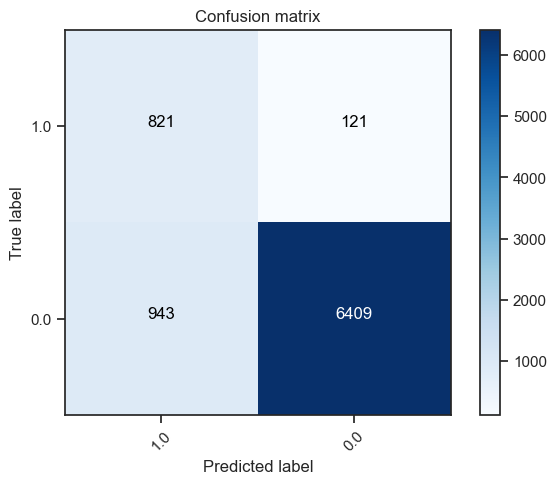

In [24]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [25]:
# Model accuracy
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.8717144924041476


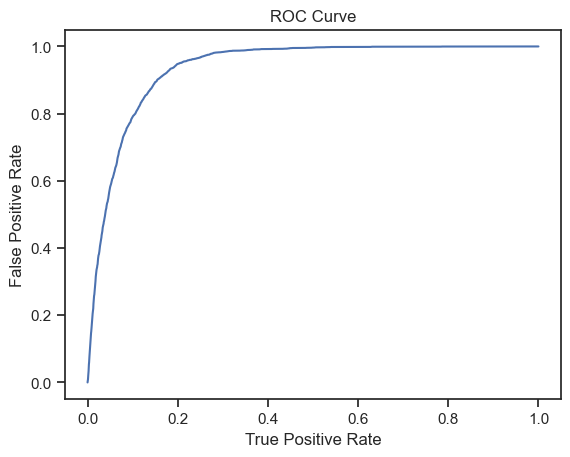

Training set area under ROC: 0.9354450536316673


In [26]:
# Training ROC for the model
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set area under ROC: ' + str(trainingSummary.areaUnderROC))

In [27]:
# Testing ROC for model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9394022222530234


# Decision Tree

In [28]:
from pyspark.ml.classification import DecisionTreeClassifier
dtc = DecisionTreeClassifier(featuresCol="features", labelCol="label")
dtcModel = dtc.fit(train_set)

predictions = dtcModel.transform(test_set)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[17348.0, 294.0]",0.0,"[0.983335222763859, 0.016664777236141026]"
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[492.0, 952.0]",1.0,"[0.3407202216066482, 0.6592797783933518]"
2,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[463.0, 1197.0]",1.0,"[0.2789156626506024, 0.7210843373493976]"
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[492.0, 952.0]",1.0,"[0.3407202216066482, 0.6592797783933518]"
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[459.0, 105.0]",0.0,"[0.8138297872340425, 0.18617021276595744]"


In [29]:
# Confusion matrix
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 840  102]
 [1084 6268]]


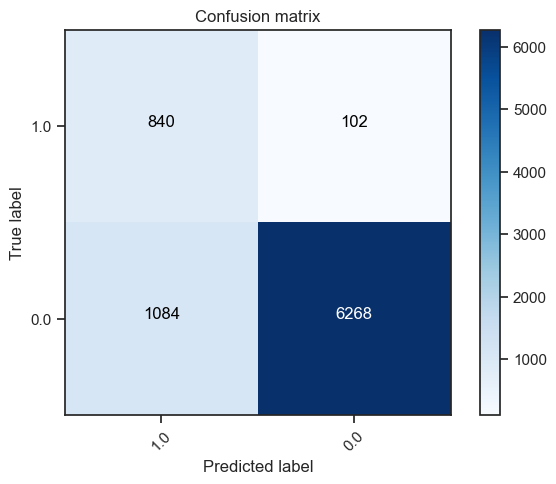

In [30]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [31]:
# Model accuracy
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.8570050639016156


/opt/homebrew/opt/apache-spark/libexec/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Testing Area Under ROC: 0.9201870918033772


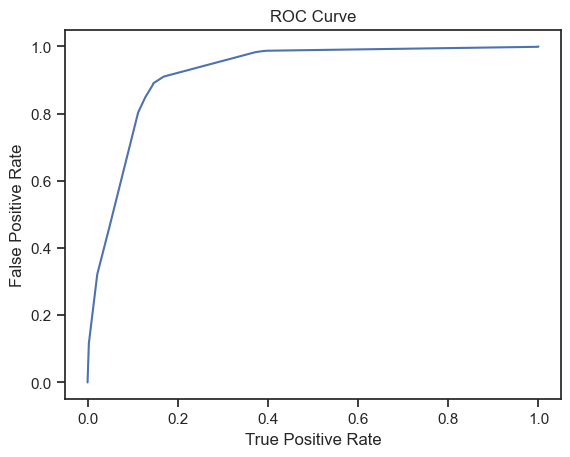

In [32]:
import matplotlib.pyplot as plt
from pyspark.mllib.evaluation import BinaryClassificationMetrics
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC Curve')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.plot(x_val, y_val)
print("Testing Area Under ROC: " + str(CurveMetrics(preds).areaUnderROC))

In [33]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8716839619590202


# Random Forest

In [34]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train_set)
predictions = rfModel.transform(test_set)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[16.54863628031938, 3.4513637196806197]",0.0,"[0.8274318140159689, 0.17256818598403098]"
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[9.71527235222658, 10.28472764777342]",1.0,"[0.48576361761132897, 0.5142363823886711]"
2,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[5.710601952314649, 14.289398047685347]",1.0,"[0.2855300976157325, 0.7144699023842676]"
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[9.652396941395486, 10.347603058604514]",1.0,"[0.4826198470697743, 0.5173801529302258]"
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[10.859207279506712, 9.140792720493288]",0.0,"[0.5429603639753356, 0.45703963602466435]"


In [35]:
# Confusion matrix
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 774  168]
 [1090 6262]]


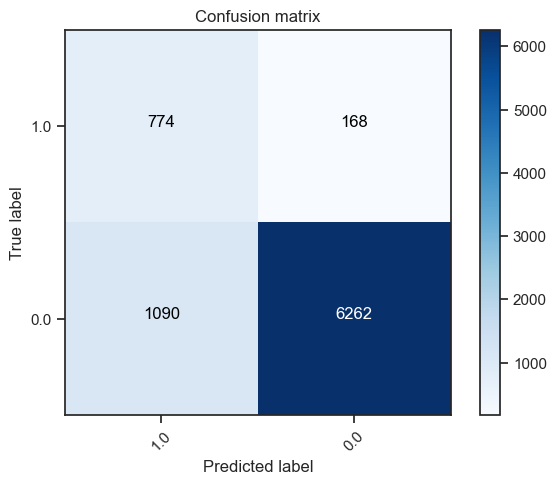

In [36]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [37]:
# Model accuracy
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.8483240897034


/opt/homebrew/opt/apache-spark/libexec/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Testing Area Under ROC: 0.9215097961413783


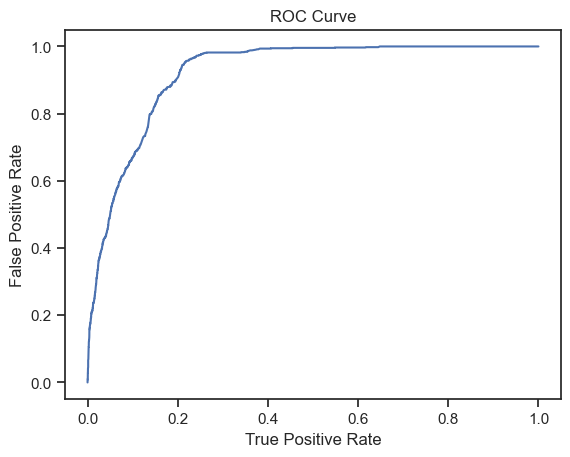

In [38]:
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC Curve')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.plot(x_val, y_val)
print("Testing Area Under ROC: " + str(CurveMetrics(preds).areaUnderROC))

In [39]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9215097961413782


# Gradient Boosting Classifier

In [40]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train_set)
predictions = gbtModel.transform(test_set)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[1.2968082075767509, -1.2968082075767509]",0.0,"[0.9304496112974169, 0.06955038870258312]"
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[-0.06204448770853599, 0.06204448770853599]",1.0,"[0.4690175018462084, 0.5309824981537916]"
2,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[-0.36155497246207724, 0.36155497246207724]",1.0,"[0.3267085198277025, 0.6732914801722976]"
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[-0.11820483897879522, 0.11820483897879522]",1.0,"[0.4411713179392003, 0.5588286820607997]"
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[0.48204869444126525, -0.48204869444126525]",0.0,"[0.7239414201889445, 0.2760585798110555]"


In [41]:
# Confusion matrix
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 856   86]
 [ 990 6362]]


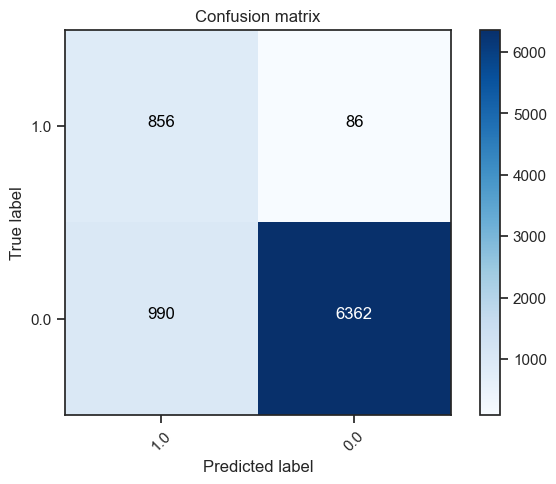

In [42]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [43]:
# Model accuracy
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.8702676633711116


/opt/homebrew/opt/apache-spark/libexec/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Testing Area Under ROC: 0.9485901838747457


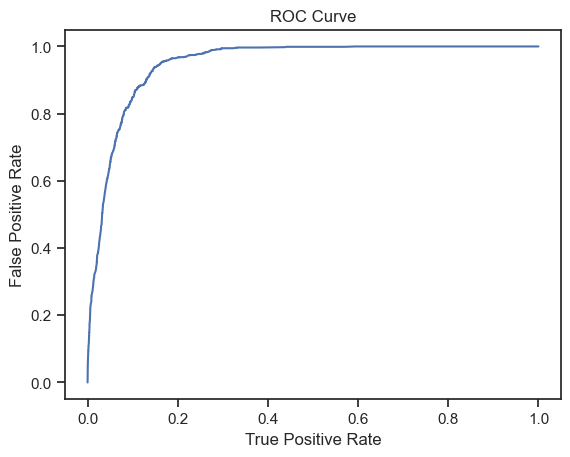

In [44]:
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC Curve')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.plot(x_val, y_val)
print("Testing Area Under ROC: " + str(CurveMetrics(preds).areaUnderROC))

In [45]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9485901838747456


In [46]:
gbtModel.featureImportances

SparseVector(53, {1: 0.0055, 2: 0.0007, 5: 0.002, 6: 0.0008, 10: 0.0004, 12: 0.0011, 13: 0.0008, 14: 0.0034, 16: 0.0013, 17: 0.0025, 21: 0.0037, 23: 0.0, 25: 0.0004, 27: 0.0089, 28: 0.0095, 29: 0.0002, 30: 0.0001, 32: 0.0004, 33: 0.0029, 34: 0.0169, 36: 0.0042, 37: 0.0012, 38: 0.0156, 39: 0.0016, 40: 0.0011, 42: 0.0096, 43: 0.0312, 44: 0.4435, 45: 0.013, 46: 0.0106, 47: 0.0021, 48: 0.0678, 49: 0.0186, 50: 0.0363, 51: 0.1649, 52: 0.1175})

# K Means

In [47]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=5, seed=1)
model = kmeans.fit(train_set.select('features'))
transformed = model.transform(train_set)


[Stage 519:==========================================>              (3 + 1) / 4]



In [48]:
transformed.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|20405|
|         3|15429|
|         4| 7981|
|         2| 2981|
|         0| 8286|
+----------+-----+



In [49]:
transformed.filter(transformed.prediction == 0).toPandas().head(20)

,label,features,age,job,marital,education,default,housing,loan,contact,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,prediction
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...",19,student,single,basic.9y,unknown,yes,no,cellular,...,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,no,0
1,0.0,"(0.0, 2.5553761110921385, 0.0, 0.0, 0.0, 0.0, ...",22,blue-collar,single,basic.6y,unknown,no,no,telephone,...,999,0,nonexistent,1.1,93.994,-36.4,4.864,5191.0,no,0
2,0.0,"(0.0, 2.5553761110921385, 0.0, 0.0, 0.0, 0.0, ...",22,blue-collar,single,basic.6y,unknown,unknown,unknown,telephone,...,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no,0
3,0.0,"(0.0, 2.5553761110921385, 0.0, 0.0, 0.0, 0.0, ...",22,blue-collar,single,basic.6y,unknown,yes,no,cellular,...,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,no,0
4,0.0,"(0.0, 2.5553761110921385, 0.0, 0.0, 0.0, 0.0, ...",22,blue-collar,single,unknown,unknown,no,no,cellular,...,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,no,0
5,0.0,"(0.0, 2.5553761110921385, 0.0, 0.0, 0.0, 0.0, ...",22,blue-collar,single,unknown,unknown,unknown,unknown,cellular,...,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,no,0
6,0.0,"(0.0, 0.0, 0.0, 3.5498633758318805, 0.0, 0.0, ...",22,services,married,basic.9y,unknown,no,no,telephone,...,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no,0
7,0.0,"(0.0, 0.0, 0.0, 3.5498633758318805, 0.0, 0.0, ...",22,services,married,high.school,unknown,yes,no,cellular,...,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,no,0
8,0.0,"(0.0, 0.0, 2.708579337991304, 0.0, 0.0, 0.0, 0...",22,technician,married,basic.9y,unknown,no,no,telephone,...,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no,0
9,0.0,"(0.0, 2.5553761110921385, 0.0, 0.0, 0.0, 0.0, ...",23,blue-collar,married,basic.9y,unknown,yes,no,cellular,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no,0


In [50]:
transformed.filter(transformed.prediction == 1).toPandas().head(20)

,label,features,age,job,marital,education,default,housing,loan,contact,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,prediction
0,0.0,"(2.2575892509892865, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20,admin.,single,high.school,no,no,no,cellular,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no,1
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.665...",20,entrepreneur,single,high.school,no,no,no,telephone,...,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no,1
2,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.665...",20,entrepreneur,single,high.school,no,no,no,telephone,...,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no,1
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.665...",20,entrepreneur,single,high.school,no,no,no,telephone,...,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no,1
4,0.0,"(0.0, 0.0, 0.0, 3.5498633758318805, 0.0, 0.0, ...",20,services,single,high.school,no,no,no,telephone,...,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,no,1
5,0.0,"(0.0, 0.0, 0.0, 3.5498633758318805, 0.0, 0.0, ...",20,services,single,high.school,no,yes,no,telephone,...,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no,1
6,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...",20,student,single,high.school,no,yes,no,cellular,...,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,no,1
7,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...",20,student,single,high.school,no,yes,yes,cellular,...,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,no,1
8,0.0,"(2.2575892509892865, 0.0, 0.0, 0.0, 0.0, 0.0, ...",21,admin.,married,unknown,no,yes,no,cellular,...,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,no,1
9,0.0,"(2.2575892509892865, 0.0, 0.0, 0.0, 0.0, 0.0, ...",21,admin.,single,high.school,no,yes,no,cellular,...,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,no,1


In [51]:
transformed.filter(transformed.prediction == 2).toPandas().head(20)

,label,features,age,job,marital,education,default,housing,loan,contact,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,prediction
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 4.107637800298967, 0...",36,retired,married,high.school,no,yes,no,cellular,...,999,0,nonexistent,-1.8,93.075,-47.1,1.435,5099.1,no,2
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 4.107637800298967, 0...",37,retired,divorced,basic.9y,unknown,yes,no,cellular,...,999,1,failure,-0.1,93.200,-42.0,4.153,5195.8,no,2
2,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 4.107637800298967, 0...",40,retired,divorced,basic.4y,no,no,no,cellular,...,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no,2
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 4.107637800298967, 0...",40,retired,single,basic.4y,no,yes,yes,cellular,...,999,0,nonexistent,-1.8,93.075,-47.1,1.453,5099.1,no,2
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 4.107637800298967, 0...",44,retired,divorced,professional.course,no,yes,no,cellular,...,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no,2
5,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 4.107637800298967, 0...",44,retired,single,basic.9y,no,no,no,cellular,...,999,1,failure,-0.1,93.200,-42.0,4.191,5195.8,no,2
6,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 4.107637800298967, 0...",45,retired,married,basic.4y,no,no,no,cellular,...,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no,2
7,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 4.107637800298967, 0...",46,retired,married,basic.6y,unknown,yes,no,cellular,...,999,0,nonexistent,-1.8,93.075,-47.1,1.498,5099.1,no,2
8,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 4.107637800298967, 0...",47,retired,married,basic.4y,no,no,no,telephone,...,999,0,nonexistent,1.4,93.918,-42.7,4.955,5228.1,no,2
9,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 4.107637800298967, 0...",47,retired,married,basic.4y,no,unknown,unknown,telephone,...,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no,2


In [52]:
transformed.filter(transformed.prediction == 3).toPandas().head(20)

,label,features,age,job,marital,education,default,housing,loan,contact,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,prediction
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...",18,student,single,high.school,no,yes,yes,cellular,...,999,0,nonexistent,-1.8,92.843,-50.0,1.687,5099.1,no,3
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...",19,student,single,basic.9y,no,no,no,cellular,...,999,0,nonexistent,-1.8,93.075,-47.1,1.410,5099.1,no,3
2,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...",19,student,single,basic.9y,no,no,no,cellular,...,999,0,nonexistent,-1.8,93.075,-47.1,1.453,5099.1,no,3
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...",19,student,single,unknown,no,yes,no,telephone,...,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,no,3
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...",20,student,single,basic.9y,no,yes,no,cellular,...,999,0,nonexistent,-1.8,92.843,-50.0,1.538,5099.1,no,3
5,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...",20,student,single,high.school,no,yes,no,cellular,...,999,1,failure,-1.8,93.075,-47.1,1.435,5099.1,no,3
6,0.0,"(2.2575892509892865, 0.0, 0.0, 0.0, 0.0, 0.0, ...",21,admin.,single,high.school,no,yes,no,cellular,...,999,0,nonexistent,-1.8,93.075,-47.1,1.415,5099.1,no,3
7,0.0,"(0.0, 0.0, 0.0, 3.5498633758318805, 0.0, 0.0, ...",21,services,single,basic.9y,no,no,no,cellular,...,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,no,3
8,0.0,"(0.0, 0.0, 0.0, 3.5498633758318805, 0.0, 0.0, ...",21,services,single,high.school,no,yes,no,cellular,...,999,0,nonexistent,-1.8,93.075,-47.1,1.435,5099.1,no,3
9,0.0,"(0.0, 0.0, 0.0, 3.5498633758318805, 0.0, 0.0, ...",21,services,single,high.school,no,yes,yes,cellular,...,999,0,nonexistent,-1.8,93.075,-47.1,1.435,5099.1,no,3


In [53]:
transformed.filter(transformed.prediction == 4).toPandas().head(20)

,label,features,age,job,marital,education,default,housing,loan,contact,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,prediction
0,0.0,"(0.0, 0.0, 0.0, 3.5498633758318805, 0.0, 0.0, ...",26,services,single,high.school,no,no,no,cellular,...,1,3,success,-1.8,93.075,-47.1,1.483,5099.1,no,4
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.61841138...",28,self-employed,married,university.degree,no,yes,no,telephone,...,999,1,failure,-0.1,93.200,-42.0,4.120,5195.8,no,4
2,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...",28,student,single,university.degree,no,yes,no,cellular,...,11,2,failure,-1.8,93.075,-47.1,1.453,5099.1,no,4
3,0.0,"(0.0, 0.0, 2.708579337991304, 0.0, 0.0, 0.0, 0...",28,technician,single,professional.course,no,yes,no,cellular,...,999,2,failure,-1.8,93.075,-47.1,1.483,5099.1,no,4
4,0.0,"(2.2575892509892865, 0.0, 0.0, 0.0, 0.0, 0.0, ...",29,admin.,divorced,professional.course,no,no,yes,cellular,...,999,1,failure,-0.1,93.200,-42.0,4.120,5195.8,no,4
5,0.0,"(2.2575892509892865, 0.0, 0.0, 0.0, 0.0, 0.0, ...",29,admin.,married,high.school,no,yes,yes,cellular,...,999,1,failure,-0.1,93.200,-42.0,4.191,5195.8,no,4
6,0.0,"(2.2575892509892865, 0.0, 0.0, 0.0, 0.0, 0.0, ...",29,admin.,married,university.degree,no,no,no,cellular,...,999,1,failure,-0.1,93.200,-42.0,4.191,5195.8,no,4
7,0.0,"(2.2575892509892865, 0.0, 0.0, 0.0, 0.0, 0.0, ...",29,admin.,single,high.school,no,yes,no,cellular,...,999,1,failure,-0.1,93.200,-42.0,4.076,5195.8,no,4
8,0.0,"(2.2575892509892865, 0.0, 0.0, 0.0, 0.0, 0.0, ...",29,admin.,single,professional.course,no,no,no,telephone,...,999,1,failure,-0.1,93.200,-42.0,4.021,5195.8,no,4
9,0.0,"(2.2575892509892865, 0.0, 0.0, 0.0, 0.0, 0.0, ...",29,admin.,single,university.degree,no,yes,no,cellular,...,5,2,success,-1.8,93.075,-47.1,1.498,5099.1,no,4


In [57]:
# Pipeline stages
stages = []

In [59]:
from pyspark.ml.feature import PCA
# Apply PCA for dimensionality reduction
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
stages += [pca]

In [60]:
# Define and add the K-means model to the pipeline
kmeans = KMeans().setK(3).setSeed(1).setFeaturesCol("pcaFeatures")
stages += [kmeans]

In [61]:
# Create a Pipeline
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(train)

# Transform the test set
test_set = pipelineModel.transform(test)


23/11/28 10:35:48 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [62]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol="pcaFeatures")
silhouette = evaluator.evaluate(test_set)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.5687624535573819


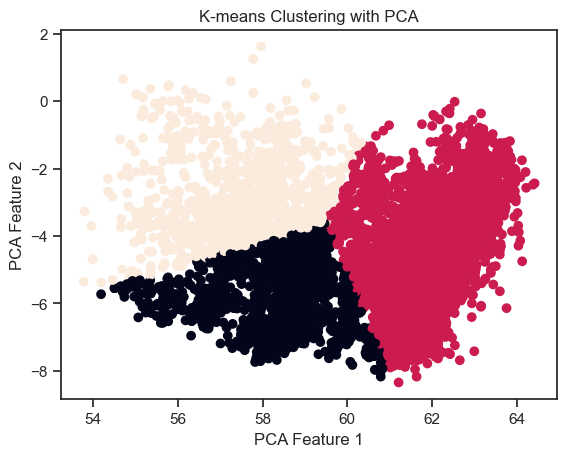

In [63]:
# Convert predictions to Pandas DataFrame for plotting
pandas_df = test_set.toPandas()

# Extract the PCA features for plotting
pandas_df['PCA1'] = pandas_df['pcaFeatures'].apply(lambda x: x[0])
pandas_df['PCA2'] = pandas_df['pcaFeatures'].apply(lambda x: x[1])

plt.scatter(pandas_df['PCA1'], pandas_df['PCA2'], c=pandas_df['prediction'])
plt.title("K-means Clustering with PCA")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.show()